In [ ]:
import lightning
import torch
import torchvision
from einops import rearrange
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms

Load the datasets

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ]
)

In [ ]:
train_dataset = torchvision.datasets.MNIST(r"/raid/arjun/MNIST/", train=True, transform=transforms)
train_dataset


Dataset MNIST
    Number of datapoints: 60000
    Root location: /raid/arjun/MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
val_dataset = torchvision.datasets.MNIST(r"/raid/arjun/MNIST/", train=False, transform=transforms)
val_dataset


Dataset MNIST
    Number of datapoints: 10000
    Root location: /raid/arjun/MNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
dataset = train_dataset + val_dataset
dataset, len(dataset)

(<torch.utils.data.dataset.ConcatDataset object at 0x7f1438214f70>, 70000)

Visualize the dataset

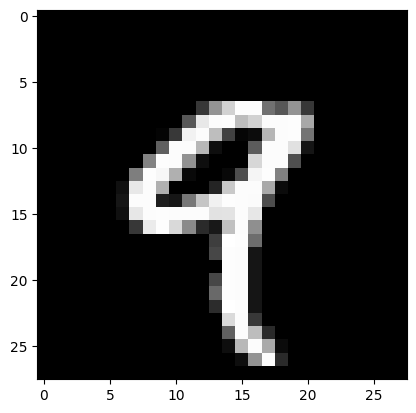

9

In [ ]:
img, gt = dataset[4]

plt.imshow(rearrange(img, "c h w -> h w c"), cmap="gray")
plt.show()
gt

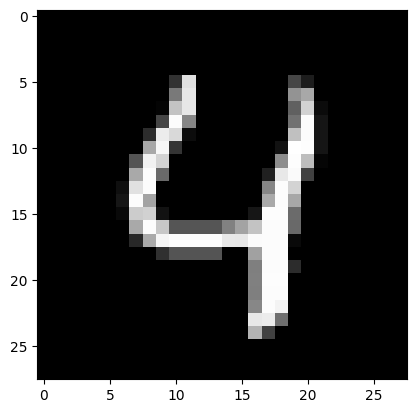

4

In [ ]:
img, gt = dataset[60004]

plt.imshow(rearrange(img, "c h w -> h w c"), cmap="gray")
plt.show()
gt

Gaussian noise

In [ ]:
class NoiseScheduler(nn.Module):
    def __init__(self, betas):
        super().__init__()

        self.betas = betas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def add_noise(self, x0_batch, t):
        standard_noise = torch.randn(x0_batch.shape, device=x0_batch.device)
        return self.sqrt_alphas_cumprod[t] * x0_batch + self.sqrt_one_minus_alphas_cumprod[t] * standard_noise

    def remove_noise(self, xt_batch, pred_batch, t):  # pred_batch is the noise prediction, not the denoised image
        x0_batch = (xt_batch - (self.sqrt_one_minus_alphas_cumprod[t] * pred_batch)) / self.sqrt_alphas_cumprod[t]
        x0_batch = x0_batch.clamp(-1.0, 1.0)

        mean_batch = xt_batch - ((self.betas[t] * pred_batch) / (self.sqrt_one_minus_alphas_cumprod[t])) / torch.sqrt(
            self.alphas[t]
        )

        if t == 0:
            return x0_batch, mean_batch

        variance_batch = self.betas[t] * (1.0 - self.alphas_cumprod[t - 1]) / (1.0 - self.alphas_cumprod[t])
        sigma_batch = torch.sqrt(variance_batch)
        standard_noise = torch.randn(xt_batch.shape, device=xt_batch.device)

        return x0_batch, mean_batch + sigma_batch * standard_noise

Visualize some outputs

t = 0
beta = 9.999999747378752e-05


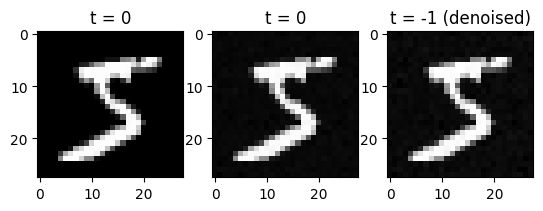


t = 20
beta = 0.002090000081807375


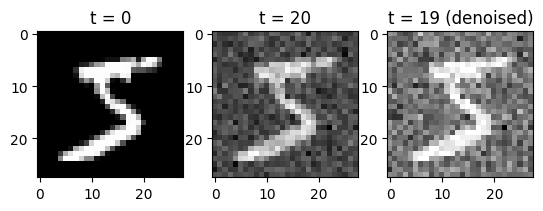


t = 40
beta = 0.0040799998678267


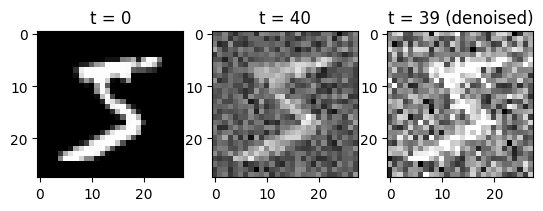


t = 60
beta = 0.006070000119507313


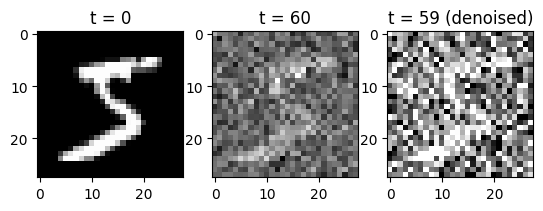


t = 80
beta = 0.008059999905526638


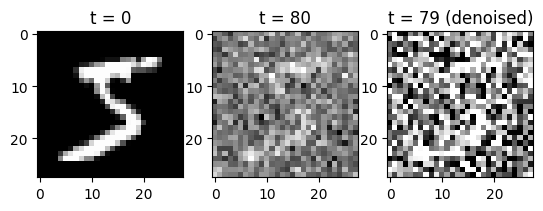


t = 100
beta = 0.010049999691545963


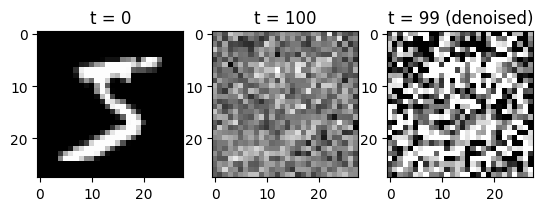


t = 120
beta = 0.012039999477565289


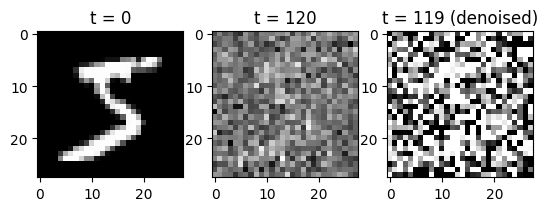


t = 140
beta = 0.014029999263584614


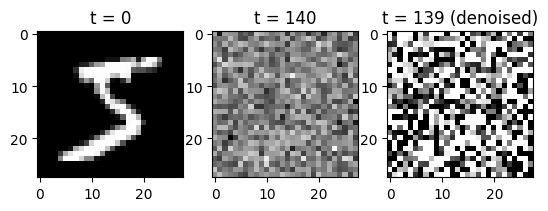


t = 160
beta = 0.016019999980926514


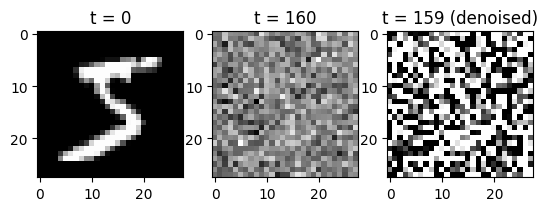


t = 180
beta = 0.01800999976694584


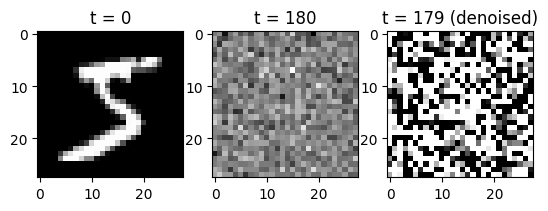


t = 200
beta = 0.019999999552965164


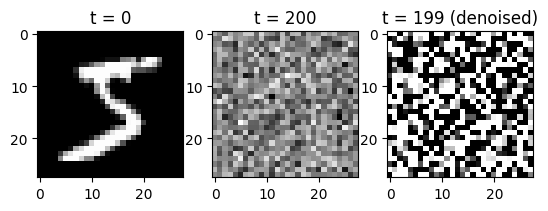

In [ ]:
T = 200
num_timesteps = 11
timesteps = torch.linspace(0, T, num_timesteps)
betas = torch.linspace(0.0001, 0.02, T + 1)

x0, gt = dataset[0]
x0.unsqueeze_(0)
scheduler = NoiseScheduler(betas)

for i in range(num_timesteps):
    t = timesteps[i].int()
    beta = betas[t]

    xt = scheduler.add_noise(x0, t)

    random_noise = torch.randn(xt.shape)
    x0_bar, mean = scheduler.remove_noise(xt, random_noise, t)

    fig, ax = plt.subplots(1, 3)

    print(f"t = {t}")
    print(f"beta = {beta}")
    # print(f'denoising mean = {mean}')

    ax[0].imshow(rearrange(x0, "1 c h w -> h w c"), cmap="gray")
    ax[0].set_title("t = 0")
    ax[1].imshow(rearrange(xt, "1 c h w -> h w c"), cmap="gray")
    ax[1].set_title(f"t = {t}")
    ax[2].imshow(rearrange(x0_bar, "1 c h w -> h w c"), cmap="gray")
    ax[2].set_title(f"t = {t - 1} (denoised)")
    plt.show()

    print()

# 